In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

# sets the default float-type
tf.keras.backend.set_floatx('float32')

class TwoDBeam:

  def __init__(self, E, nu, H, L, t, c=None, c1=None, c2=None, xmin=0, N_H=100, N_L=1000, num_hidden_layers=2, num_neurons_per_layer=30, activation='tanh', actual_solution=None, epochs=5000):

    self.H = H
    self.L = L
    self.E = E
    self.nu = nu
    self.lambdaa = self.E*self.nu/((1+self.nu)*(1-2*self.nu))
    self.mu = self.E/(2*(1+self.nu))
    self.N_L = N_L
    self.N_H = N_H
    self.N = self.N_H*self.N_L
    self.epochs = epochs
    self.xmin = xmin
    self.xmax = self.L
    self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
    self.X = self.get_data()
    self.t = tf.constant(t, dtype=tf.float32)
    self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,10000],[1e-2,1e-4,5e-5])
    # self.learning_rate = 1e-3
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.actual_solution = actual_solution
    #Mooney-rivlin params
    self.c = c
    self.c1 = c1
    self.c2 = c2
    self.d = 2*(self.c1+2*self.c2)
  
  def get_data(self):

    # X = tf.random.uniform((self.N, 1), minval=self.xmin, maxval=self.xmax)
    # X = tf.expand_dims(tf.sort(tf.squeeze(X)), axis=-1)
    X1 = tf.linspace(start=0, stop=4, num=self.N_L)
    X2 = tf.linspace(start=0, stop=1, num=self.N_H)
    data = []
    for x2 in X2:
      for x1 in X1:
        data.append([x1.numpy(), x2.numpy()])

    X = tf.constant(data, dtype=tf.float32)
    print('Data obtained')
    return X
  
  def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.Input(2))
    # Add the hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation, kernel_initializer='glorot_normal'))
    # Add output layer
    model.add(tf.keras.layers.Dense(2))
    return model
  
  
  def psi(self, I1, I2, J, model):
    if model == 'neo-hookean':
      return (self.lambdaa/2)*tf.square(tf.math.log(J)) - self.mu*tf.math.log(J) + 0.5*self.mu*(I1-2)
    else:
      return self.c*tf.square(J-1) - self.d*tf.math.log(J) + self.c1*(I1-2) + self.c2*(I2-1)

  def trapz1D(self, y, x):
    # Assuming X is sorted
    h = (x[-1] - x[0])/(x.shape[0]-1)
    integrand = y
    integrand1 = integrand[1:]
    integrand0 = integrand[:-1]
    integral = (h/2)*tf.reduce_sum(integrand1 + integrand0)
    return integral
  
  def trapz2D(self, y):

    hx = (self.xmax - self.xmin)/(self.N_L-1)
    hy = (self.H)/(self.N_H-1)
    integral = (hx*hy/4)*(y[0] + y[self.N_L*self.N_H-1] + y[self.N_L*self.N_H-self.N_L] + y[self.N_L-1])
    integral += (hx*hy/2)*tf.reduce_sum(y[::self.N_L][1:] + y[self.N_L-1::self.N_L][1:])
    integral += (hx*hy/2)*tf.reduce_sum(y[:self.N_L][1:] + y[-self.N_L:][1:])
    integral += (hx*hy)*(tf.reduce_sum(y[self.N_L:])-tf.reduce_sum(y[self.N_L::self.N_L]))
    return integral

  def get_loss(self):

    X = self.X
    X_B = tf.concat([tf.ones(shape=(500, 1), dtype=tf.float32)*self.L, tf.expand_dims(tf.cast(tf.linspace(start=0, stop=self.H, num=500, ), dtype=tf.float32), axis=-1)], axis=1)
    t = tf.ones(shape=(500, 2), dtype=tf.float32)*self.t

    with tf.GradientTape(persistent=True) as tape:

      tape.watch(X)
      u = self.predict(X)
      u_B = self.predict(X_B)
      phi = X + u
      F = tape.batch_jacobian(phi, X)
      C = tf.matmul(tf.transpose(F, perm=[0, 2, 1]), F)
      # u1X1 = tape.gradient(u1, X1)
      # u2X1 = tape.gradient(u2, X1)
      # u1X2 = tape.gradient(u1, X2)
      # u2X2 = tape.gradient(u2, X2)
      I1 = tf.linalg.trace(C)
      I2 = 0.5*(I1**2 - tf.linalg.trace(tf.matmul(C, C)))
      J = tf.math.sqrt(tf.linalg.det(C))

      psi_of_X = self.psi(I1, I2, J, model='neo-hookean')
      integral = self.trapz2D(psi_of_X)
      integral -= (t[0, 1]*self.trapz1D(u_B[:, 1], X_B[:, 1]))
    return integral


  
  def get_gradients(self):
    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(self.model.trainable_variables)
      loss = self.get_loss()

    g = tape.gradient(loss, self.model.trainable_variables)
    del tape
    return loss, g
  
  @tf.function
  def train_step(self):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_gradients()
    # Perform gradient descent step
    self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
    return loss
  
  def train(self):
    epochs = self.epochs
    hist = []

    # Start timer
    t0 = time()

    for i in range(epochs+1):
        
        loss = self.train_step()
        # Append current loss to hist
        hist.append(loss.numpy())
        # Output current loss after 50 iterates
        if i%50 == 0:
            print(f'It {i}: loss = {loss.numpy()}')
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))
  
  def plot_results(self):
    X_B = tf.concat([tf.ones(shape=(500, 1), dtype=tf.float32)*self.L, tf.expand_dims(tf.cast(tf.linspace(start=0, stop=self.H, num=500, ), dtype=tf.float32), axis=-1)], axis=1)
    X_M = tf.concat([tf.ones(shape=(500, 1), dtype=tf.float32)*self.L/2, tf.expand_dims(tf.cast(tf.linspace(start=0, stop=self.H, num=500, ), dtype=tf.float32), axis=-1)], axis=1)
    X_0 = tf.concat([tf.ones(shape=(500, 1), dtype=tf.float32)*0, tf.expand_dims(tf.cast(tf.linspace(start=0, stop=self.H, num=500, ), dtype=tf.float32), axis=-1)], axis=1)
    u_pred_B = self.predict(X_B)
    u_pred_M = self.predict(X_M)
    u_pred_0 = self.predict(X_0)
    u2_B = u_pred_B[:, 1]
    u2_M = u_pred_M[:, 1]
    u2_0 = u_pred_0[:, 1]
    X2 = X_B[:, 1]
    plt.figure(figsize=(10, 10))
    plt.plot(X2, u2_B, label='predicted')
    plt.title('Displacement in Y-direction at the end')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.plot(X2, u2_M, label='predicted')
    plt.title('Displacement in Y-direction at the middle')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.plot(X2, u2_0, label='predicted')
    plt.title('Displacement in y-direction at X=0')
    plt.show()
    phi = self.X + self.predict(self.X)
    plt.scatter(phi[:, 0], phi[:, 1])
    plt.show()
    
  def predict(self, X):
    N = X.shape[0]
    A = tf.stack([tf.ones(shape=(N,), dtype=tf.float32), tf.zeros(shape=(N,), dtype=tf.float32)], axis=1)
    B = tf.stack([tf.zeros(shape=(N,), dtype=tf.float32), tf.ones(shape=(N,), dtype=tf.float32)], axis=1)
    reverse_matrix = tf.reverse(tf.eye(2), [0])
    reversed_batch = tf.matmul(reverse_matrix, tf.transpose(X))
    reversed_batch = tf.transpose(reversed_batch)

    return (X*A + reversed_batch*B)*self.model(X)

Data obtained
It 0: loss = 215.89361572265625
It 50: loss = 1.6252880096435547
It 100: loss = -2.2351675033569336
It 150: loss = -2.4127864837646484
It 200: loss = -2.4975204467773438
It 250: loss = -2.550229072570801
It 300: loss = -2.5836634635925293
It 350: loss = -2.60552716255188
It 400: loss = -2.6208341121673584
It 450: loss = -2.6325769424438477
It 500: loss = -2.642343759536743
It 550: loss = -2.650911331176758
It 600: loss = -2.6586475372314453
It 650: loss = -2.6657400131225586
It 700: loss = -2.6723012924194336
It 750: loss = -2.678407907485962
It 800: loss = -2.6841156482696533
It 850: loss = -2.6894705295562744
It 900: loss = -2.694507122039795
It 950: loss = -2.699251890182495
It 1000: loss = -2.7037272453308105
It 1050: loss = -2.7079482078552246
It 1100: loss = -2.711930990219116
It 1150: loss = -2.7156858444213867
It 1200: loss = -2.719226121902466
It 1250: loss = -2.722564458847046
It 1300: loss = -2.7257089614868164
It 1350: loss = -2.728670835494995
It 1400: loss =

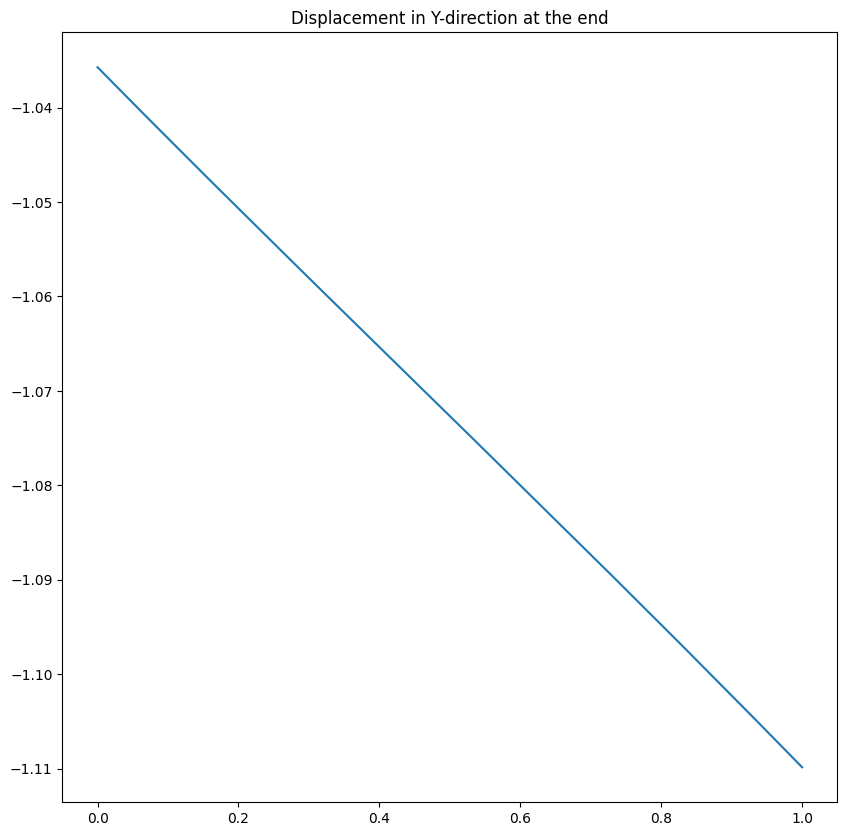

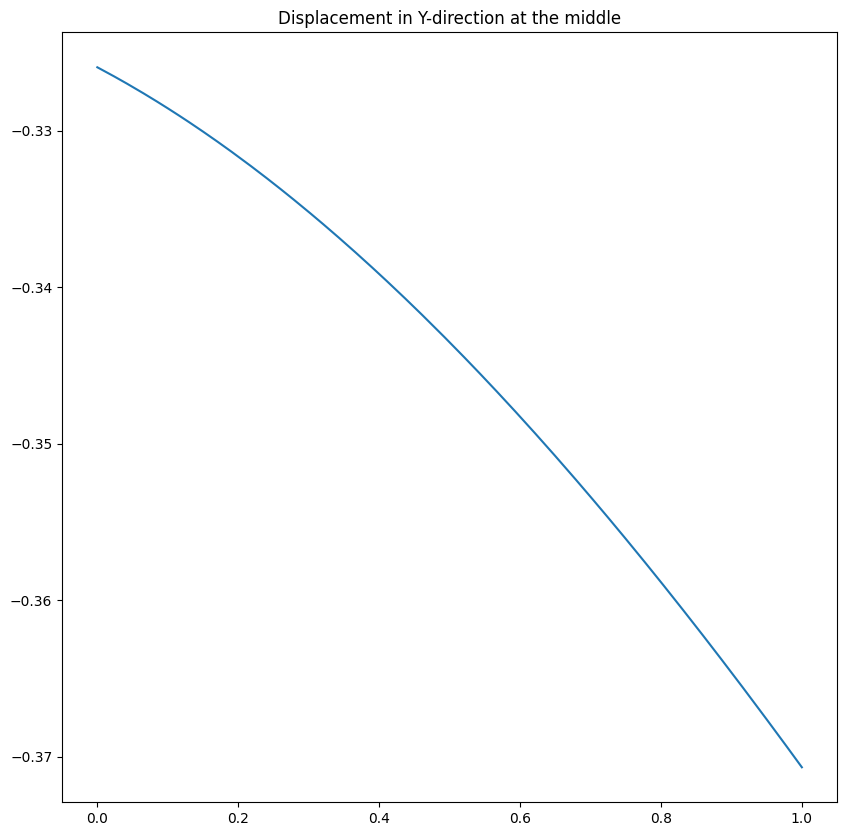

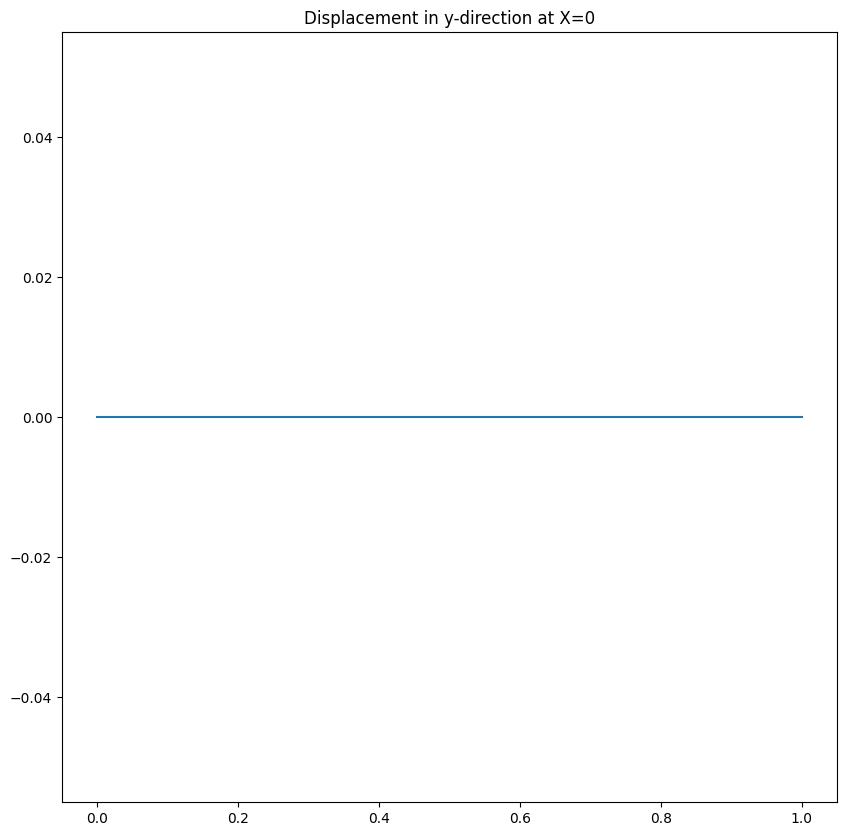

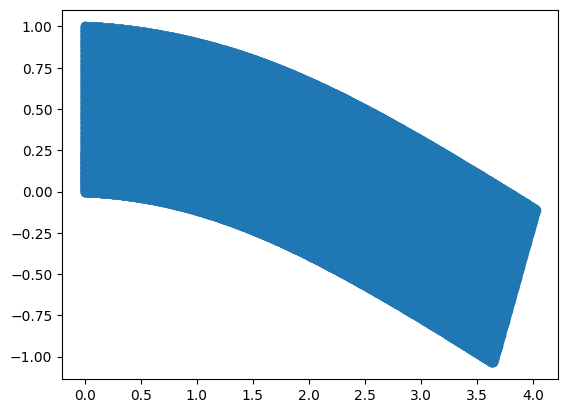

In [ ]:
N_H = 100
N_L = 1000
E = 1000
nu = 0.3
t = [0, -5]
H = 1
L = 4

model = TwoDBeam(E, nu, H, L, t, c=100, c1=630, c2=-1.2)
model.train()
model.plot_results()

In [ ]:
N = 100
A = tf.stack([tf.ones(shape=(N,), dtype=tf.float32), tf.zeros(shape=(N,), dtype=tf.float32)], axis=1)
B = tf.stack([tf.zeros(shape=(N,), dtype=tf.float32), tf.ones(shape=(N,), dtype=tf.float32)], axis=1)
reverse_matrix = tf.reverse(tf.eye(2), [0])
reversed_batch = tf.matmul(reverse_matrix, tf.transpose(X))
reversed_batch = tf.transpose(reversed_batch)
(X*A + reversed_batch*B)

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[4.       , 4.       ],
       [3.6666667, 3.6666667],
       [3.3333333, 3.3333333],
       [3.       , 3.       ],
       [2.6666667, 2.6666667],
       [2.3333333, 2.3333333],
       [2.       , 2.       ],
       [1.6666666, 1.6666666],
       [1.3333334, 1.3333334],
       [1.       , 1.       ],
       [4.       , 4.       ],
       [3.6666667, 3.6666667],
       [3.3333333, 3.3333333],
       [3.       , 3.       ],
       [2.6666667, 2.6666667],
       [2.3333333, 2.3333333],
       [2.       , 2.       ],
       [1.6666666, 1.6666666],
       [1.3333334, 1.3333334],
       [1.       , 1.       ],
       [4.       , 4.       ],
       [3.6666667, 3.6666667],
       [3.3333333, 3.3333333],
       [3.       , 3.       ],
       [2.6666667, 2.6666667],
       [2.3333333, 2.3333333],
       [2.       , 2.       ],
       [1.6666666, 1.6666666],
       [1.3333334, 1.3333334],
       [1.       , 1.       ],
       [4.       , 4

In [ ]:
reversed_batch

In [ ]:
def trapz2D(y, n1, n2, x1max, x1min, x2max, x2min):

    h1 = (x1max - x1min)/(n1-1)
    h2 = (x2max - x2min)/(n2-1)
    integral = (h1*h2/4)*(y[0] + y[n1*n2-1] + y[n1*n2-n1] + y[n1-1])
    integral += (h1*h2/2)*tf.reduce_sum(y[::n1][1:] + y[n1-1::n1][1:])
    integral += (h1*h2/2)*tf.reduce_sum(y[:n1][1:] + y[-n1:][1:])
    integral += (h1*h2)*(tf.reduce_sum(y[n1:])-tf.reduce_sum(y[n1::n1]))
    return integral


def get_data(n1, n2, x1max, x1min, x2max, x2min):

  # X = tf.random.uniform((self.N, 1), minval=self.xmin, maxval=self.xmax)
  # X = tf.expand_dims(tf.sort(tf.squeeze(X)), axis=-1)
  X1 = tf.linspace(start=x1min, stop=x1max, num=n1)
  X2 = tf.linspace(start=x2min, stop=x2max, num=n2)
  data = []
  y = []
  for x2 in X2:
    for x1 in X1:
      data.append([x1.numpy(), x2.numpy()])
      y.append([x1.numpy()*x2.numpy() ,x1.numpy()**2 + x2.numpy()**2])

  X = tf.constant(data, dtype=tf.float32)
  y = tf.constant(y, dtype=tf.float32)
  print('Data obtained')
  return X, y
  

In [ ]:
X, y = get_data(10, 10, 1, 4, 1, 5)


Data obtained


In [ ]:
# Define the function y = x^2
def func(x):
    # y = []
    # for i in range(x.shape[0]):
    #   y.append([x[i,0].numpy()*x[i, 1].numpy() ,x[i, 0].numpy()**2 + x[i, 1].numpy()**2])
    # y = tf.constant(y, dtype=tf.float32)
    # return y
    N = x.shape[0]
    A = tf.stack([tf.ones(shape=(N,), dtype=tf.float32), tf.zeros(shape=(N,), dtype=tf.float32)], axis=1)
    B = tf.stack([tf.zeros(shape=(N,), dtype=tf.float32), tf.ones(shape=(N,), dtype=tf.float32)], axis=1)
    reverse_matrix = tf.reverse(tf.eye(2), [0])
    reversed_batch = tf.matmul(reverse_matrix, tf.transpose(x))
    reversed_batch = tf.transpose(reversed_batch)

    return (x*A + reversed_batch*B)

# Use a gradient tape to compute the Jacobian of y with respect to x
with tf.GradientTape(persistent=True) as tape:
    tape.watch(X)
    z = func(X)
jacobian = tape.batch_jacobian(z, X)

# Print the result
print(jacobian)

tf.Tensor(
[[[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]


In [ ]:
C = tf.matmul(tf.transpose(jacobian, perm=[0, 2, 1]), jacobian)
I1 = tf.linalg.trace(C)

In [ ]:
J = tf.linalg.det(C)
J

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>